## Installing necessary Packages

In [ ]:
!pip3 install -q torch torchvision torchaudio opencv-python numpy matplotlib supervision kornia diffusers==0.32.2 transformers==4.49 accelerate safetensors scikit-image ffmpeg-python scikit-video

!mkdir grounding
%cd grounding
!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd /content/grounding/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

%cd /content/grounding/GroundingDINO
!pip install -e .
%cd ..
%cd ..

!mkdir sam_2
%cd sam_2
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

%cd ..
%cd ..

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.8 MB/s eta 0:00:00
/content/grounding
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 27.77 MiB/s, done.
Resolving deltas: 100% (221/221), done.
/content/grounding/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
/content/grounding

##Adding to path

In [ ]:
import sys
sys.path.append("/content/sam_2/segment-anything-2/")
sys.path.append("/content/grounding/GroundingDINO/")

## Importing Libraries

In [ ]:
import torch
import cv2
import numpy as np
from pathlib import Path
import base64
from diffusers import StableDiffusionInpaintPipeline
import supervision as sv
import kornia
import kornia.contrib as kcontrib
import kornia.geometry.transform as K
from torchvision.ops import box_convert
from groundingdino.util.inference import load_model, load_image, predict, annotate
from sam2.build_sam import build_sam2,build_sam2_video_predictor
from itertools import islice

## Defining Configurations

In [ ]:
SOURCE_VIDEO = "example_video.mp4"
SCALE_FACTOR = 0.25
HOME = "/content"

TEXT_PROMPT = "dog"
REPLACEMENT_PROMPT = "A German Shepherd dog in the same pose"

BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Extracting Frames from Source Video

In [ ]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

for frame in islice(frames_generator, 100):
    frame = sv.scale_image(frame, SCALE_FACTOR)
    images_sink.save_image(frame)

SOURCE_FRAME_PATHS = sorted(
    sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"])
)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"

## Functions to Load Images and frames

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64," + encoded

## Load Models

In [ ]:
dino_model = load_model(
    "/content/grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
    "/content/groundingdino_swint_ogc.pth"
)

CHECKPOINT = f"{HOME}/sam2.1_hiera_large.pt"
CONFIG = "/configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting"
).to(DEVICE)

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Functions

In [ ]:
def predict_boxes(image, prompt):
    boxes, logits, phrases = predict(dino_model, image, prompt,
                                     box_threshold=BOX_THRESHOLD,
                                     text_threshold=TEXT_THRESHOLD)
    return boxes, logits, phrases

def convert_boxes_sam(boxes, image_shape):
    h, w, _ = image_shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    input_box = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    return input_box

def stable_diffusion_inpaint(frame, mask, prompt):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
    mask_resized = (mask_resized > 128).astype(np.uint8) * 255
    result = pipe(prompt=prompt, image=frame_rgb, mask_image=mask_resized).images[0]
    return cv2.cvtColor(np.array(result), cv2.COLOR_RGB2BGR)


def tensor_to_numpy_bgr(frame_tensor):
    if frame_tensor.ndim == 4:
        frame_tensor = frame_tensor.squeeze(0)
    frame_np = frame_tensor.permute(1, 2, 0).cpu().numpy()
    frame_np = (frame_np * 255).astype(np.uint8)
    frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)
    return frame_bgr

##Load Image for grounding dino

In [ ]:
image_path = "/content/Screenshot 2025-10-15 201131.png"
image_source, image = load_image(image_path)


##Converting to Region Seeds and generating Boxes using GroundingDINO

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from groundingdino.util import box_ops
from sam2.sam2_image_predictor import SAM2ImagePredictor


final text_encoder_type: bert-base-uncased
Detected phrases: ['fire hydrant']


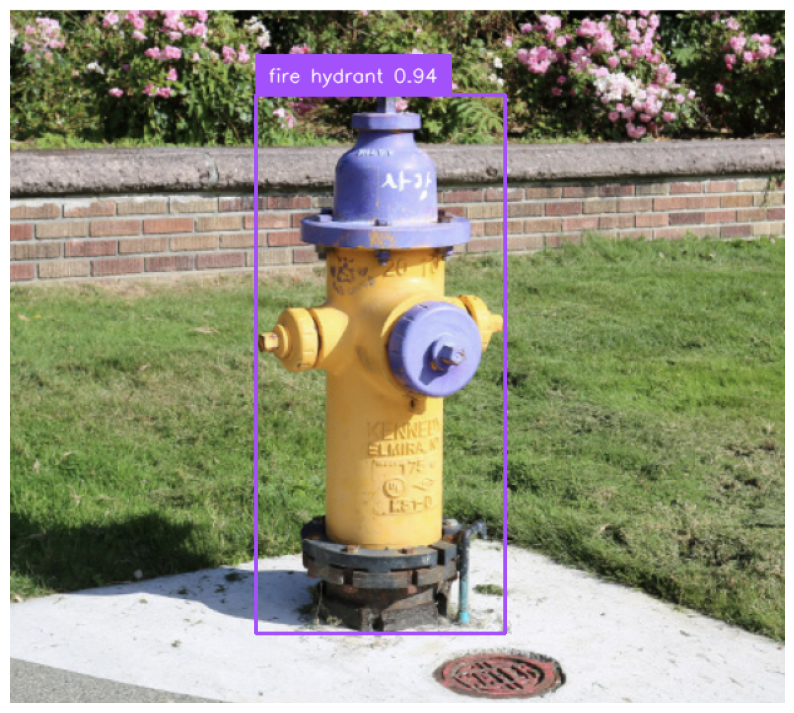

True

In [ ]:
text_prompt = "fire hydrant"
dino_model = load_model("/content/grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "/content/groundingdino_swint_ogc.pth")
boxes, logits, phrases = predict(dino_model, image, text_prompt, box_threshold=0.3, text_threshold=0.25)

print("Detected phrases:", phrases)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

cv2.imwrite("annotated_image.jpg", annotated_frame)


##Converting Boxes to SAM2 format (xyxy)

In [ ]:
h, w, _ = image_source.shape
boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
input_box = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()

##Loading image for SAM2

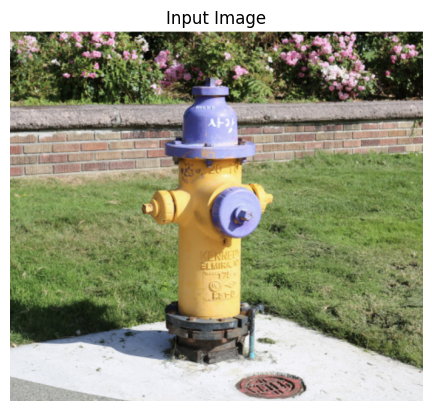

In [ ]:
image = Image.open(image_path)
image = np.array(image.convert("RGB"))
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")
plt.show()

##Feeding Seeds to SAM2

In [ ]:
sam2_model = build_sam2("/configs/sam2.1/sam2.1_hiera_s.yaml","sam2.1_hiera_small.pt")
predictor = SAM2ImagePredictor(sam2_model)

predictor.set_image(image)


masks, scores, logits = predictor.predict(point_coords=None,point_labels=None,box=input_box,multimask_output=False)

##Generating Overlay Mask

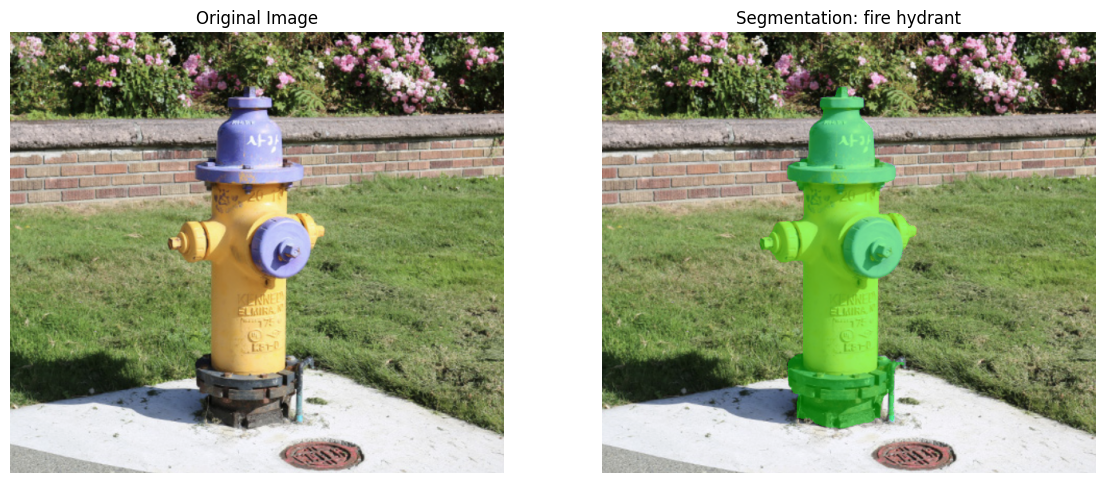

In [ ]:
mask = masks[0].astype(bool)
overlay = image.copy()
alpha = 0.4
overlay[mask] = (overlay[mask] * (1 - alpha) + np.array([0, 255, 0]) * alpha).astype(np.uint8)
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Segmentation: {phrases[0]}")
plt.axis("off")
plt.show()

In [ ]:
def show_mask(mask):
  overlay = image.copy()
  alpha = 0.4
  overlay[mask] = (overlay[mask] * (1 - alpha) + np.array([0, 255, 0]) * alpha).astype(np.uint8)
  plt.imshow(overlay)
  plt.axis("off")
  plt.show()

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16,).to('cuda')


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

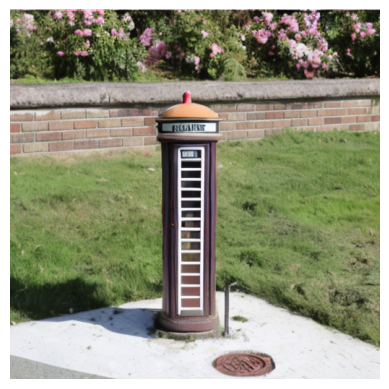

In [ ]:
mask_uint8 = (mask.astype(np.uint8)) * 255

# Convert to PIL Image
mask_pil = Image.fromarray(mask_uint8)

# Convert original image to PIL as well (required by pipeline)
image_pil = Image.fromarray(image)
prompt = "phone booth"
# Run inpainting
edited = pipe(prompt=prompt, image=image_pil, mask_image=mask_pil).images[0]

# Display
plt.imshow(edited)
plt.axis('off')
plt.show()

## Object Removal in Videos

In [ ]:
import os
from pathlib import Path

# Folder path
folder_path = "/content/example_video"  # replace with your folder

# Using Pathlib
folder = Path(folder_path)
for file in folder.iterdir():
    if file.is_file():  # only delete files, not subfolders
        file.unlink()

print(f"All files in {folder_path} have been deleted.")


All files in /content/example_video have been deleted.


In [ ]:
import cv2
import numpy as np
import torch
from PIL import Image
import supervision as sv
from groundingdino.util.inference import load_model, predict
from sam2.sam2_image_predictor import SAM2ImagePredictor
from diffusers import AutoPipelineForInpainting
from torchvision.ops import box_convert
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- CONFIG ---
SOURCE_VIDEO = "example_video.mp4"
SCALE_FACTOR = 1.0
HOME = "/content"
NUM_FRAMES = 80  # for testing, you can remove this later

# --- FRAME EXTRACTION ---
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

for frame in islice(frames_generator, NUM_FRAMES):
    frame = sv.scale_image(frame, SCALE_FACTOR)
    images_sink.save_image(frame)

SOURCE_FRAME_PATHS = sorted(
    sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"])
)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"


In [ ]:
# --- LOAD MODELS ---
sam2_model = build_sam2("/configs/sam2.1/sam2.1_hiera_s.yaml","sam2.1_hiera_small.pt")
predictor = SAM2ImagePredictor(sam2_model)
dino_model = load_model("/content/grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "/content/groundingdino_swint_ogc.pth")

pipe = AutoPipelineForInpainting.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16,).to('cuda')

final text_encoder_type: bert-base-uncased


model_index.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.01G [00:00<?, ?B/s]

movq/diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

image_encoder/model.safetensors:   0%|          | 0.00/3.69G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

prior/diffusion_pytorch_model.safetensor(…):   0%|          | 0.00/4.10G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

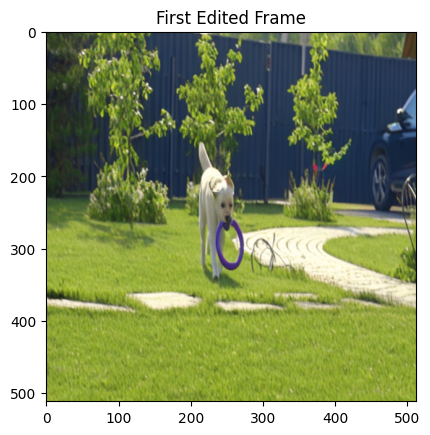

  1%|▏         | 1/80 [00:19<25:29, 19.36s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▎         | 2/80 [00:39<25:52, 19.90s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 3/80 [01:00<26:15, 20.46s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  5%|▌         | 4/80 [01:21<25:51, 20.42s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▋         | 5/80 [01:41<25:25, 20.33s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 6/80 [02:01<25:10, 20.41s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 7/80 [02:22<24:51, 20.43s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 8/80 [02:42<24:28, 20.39s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█▏        | 9/80 [03:02<24:06, 20.37s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▎        | 10/80 [03:23<23:47, 20.39s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 11/80 [03:43<23:25, 20.37s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 12/80 [04:04<23:03, 20.35s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▋        | 13/80 [04:24<22:43, 20.35s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 14/80 [04:45<22:34, 20.52s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 15/80 [05:05<22:10, 20.47s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 16/80 [05:26<21:49, 20.46s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██▏       | 17/80 [05:47<21:37, 20.59s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▎       | 18/80 [06:07<21:12, 20.53s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 19/80 [06:27<20:47, 20.45s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 20/80 [06:48<20:28, 20.48s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▋       | 21/80 [07:08<20:07, 20.47s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 22/80 [07:28<19:43, 20.40s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 23/80 [07:49<19:19, 20.34s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|███       | 24/80 [08:09<18:59, 20.35s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 31%|███▏      | 25/80 [08:30<18:46, 20.49s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▎      | 26/80 [08:50<18:22, 20.42s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 34%|███▍      | 27/80 [09:10<18:01, 20.41s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 35%|███▌      | 28/80 [09:31<17:48, 20.54s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 36%|███▋      | 29/80 [09:52<17:23, 20.47s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 38%|███▊      | 30/80 [10:12<17:01, 20.43s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 39%|███▉      | 31/80 [10:32<16:40, 20.42s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 40%|████      | 32/80 [10:53<16:19, 20.41s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 41%|████▏     | 33/80 [11:13<15:57, 20.37s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 42%|████▎     | 34/80 [11:33<15:35, 20.34s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 44%|████▍     | 35/80 [11:53<15:14, 20.32s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 45%|████▌     | 36/80 [12:14<15:02, 20.51s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 46%|████▋     | 37/80 [12:35<14:39, 20.44s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 48%|████▊     | 38/80 [12:55<14:17, 20.42s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 49%|████▉     | 39/80 [13:16<14:01, 20.53s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████     | 40/80 [13:36<13:40, 20.50s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 51%|█████▏    | 41/80 [13:57<13:17, 20.44s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 52%|█████▎    | 42/80 [14:17<12:54, 20.37s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 54%|█████▍    | 43/80 [14:37<12:34, 20.40s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 55%|█████▌    | 44/80 [14:58<12:15, 20.43s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 56%|█████▋    | 45/80 [15:18<11:52, 20.36s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 57%|█████▊    | 46/80 [15:38<11:31, 20.34s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 59%|█████▉    | 47/80 [15:59<11:17, 20.53s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 60%|██████    | 48/80 [16:20<10:54, 20.46s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 61%|██████▏   | 49/80 [16:40<10:31, 20.38s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 62%|██████▎   | 50/80 [17:00<10:12, 20.40s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 64%|██████▍   | 51/80 [17:21<09:51, 20.41s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 65%|██████▌   | 52/80 [17:41<09:29, 20.35s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 66%|██████▋   | 53/80 [18:01<09:08, 20.33s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 68%|██████▊   | 54/80 [18:21<08:48, 20.34s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 69%|██████▉   | 55/80 [18:42<08:31, 20.48s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 70%|███████   | 56/80 [19:03<08:09, 20.41s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 71%|███████▏  | 57/80 [19:23<07:49, 20.41s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 72%|███████▎  | 58/80 [19:44<07:31, 20.53s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 74%|███████▍  | 59/80 [20:04<07:10, 20.51s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 75%|███████▌  | 60/80 [20:24<06:48, 20.43s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 76%|███████▋  | 61/80 [20:45<06:26, 20.37s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 78%|███████▊  | 62/80 [21:05<06:07, 20.39s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 79%|███████▉  | 63/80 [21:26<05:47, 20.45s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 80%|████████  | 64/80 [21:46<05:26, 20.40s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 81%|████████▏ | 65/80 [22:06<05:05, 20.37s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 82%|████████▎ | 66/80 [22:27<04:47, 20.52s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 84%|████████▍ | 67/80 [22:48<04:26, 20.47s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 85%|████████▌ | 68/80 [23:08<04:04, 20.41s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 86%|████████▋ | 69/80 [23:28<03:44, 20.39s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 88%|████████▊ | 70/80 [23:49<03:23, 20.40s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 89%|████████▉ | 71/80 [24:09<03:03, 20.40s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 90%|█████████ | 72/80 [24:29<02:42, 20.37s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 91%|█████████▏| 73/80 [24:50<02:22, 20.35s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 92%|█████████▎| 74/80 [25:10<02:02, 20.49s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 94%|█████████▍| 75/80 [25:31<01:42, 20.44s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 95%|█████████▌| 76/80 [25:51<01:21, 20.40s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 96%|█████████▋| 77/80 [26:11<01:01, 20.37s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 98%|█████████▊| 78/80 [26:32<00:40, 20.39s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 99%|█████████▉| 79/80 [26:52<00:20, 20.41s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 80/80 [27:12<00:00, 20.41s/it]

✅ Video object removal complete — with temporal consistency & smooth output!


In [ ]:
text_prompt = "bike"
REPLACEMENT_PROMPT = "Remove the bike and fill the background. Make the inpainting as realistic as possible."
negative_prompt = "bike still exists, background not filled, deformed, disfigured"
# --- VIDEO INFO ---
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = 512
video_info.height = 512

# --- OPTICAL FLOW INITIALIZATION ---
prev_gray = None
prev_edited = None
flow_blend_strength = 0.25  # how strongly to blend warped previous frame

kernel = np.ones((7, 7), np.uint8)  # mask dilation kernel

with sv.VideoSink(TARGET_VIDEO, video_info=video_info) as sink:
    for frame_idx, frame_path in enumerate(tqdm(SOURCE_FRAME_PATHS)):
        # --- LOAD FRAME ---
        image_source, image = load_image(frame_path)
        boxes, logits, phrases = predict(
            dino_model, image, text_prompt, box_threshold=0.3, text_threshold=0.25
        )

        h, w, _ = image_source.shape
        boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
        input_box = box_convert(boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()

        image = Image.open(frame_path)
        image = np.array(image.convert("RGB"))

        predictor.set_image(image)
        masks, _, _ = predictor.predict(
            point_coords=None, point_labels=None, box=input_box, multimask_output=False
        )
        if masks is not None and len(masks) > 0 and masks[0].any():
            mask = masks[0].astype(np.uint8) * 255

            # --- CLEAN MASK (dilate + blur edges for smoother blending) ---
            mask = cv2.dilate(mask, kernel, iterations=1)
            mask = cv2.GaussianBlur(mask, (5, 5), 0)
            mask_pil = Image.fromarray(mask)
            image_pil = Image.fromarray(image)

            # --- INPAINT / REPLACE ---
            edited = pipe(prompt=REPLACEMENT_PROMPT, negative_prompt=negative_prompt, image=image_pil, mask_image=mask_pil).images[0]
            edited_np = np.array(edited)

            if edited_np.dtype != np.uint8:
                edited_np = (edited_np * 255).astype(np.uint8)

            if edited_np.ndim == 2:
                edited_np = cv2.cvtColor(edited_np, cv2.COLOR_GRAY2BGR)

            edited_np = cv2.resize(edited_np, (512, 512))

            # --- OPTICAL FLOW-BASED STABILIZATION ---
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

            if prev_gray is not None and prev_edited is not None:
                # Compute optical flow from previous to current frame
                flow = cv2.calcOpticalFlowFarneback(
                    prev_gray, gray, None,
                    pyr_scale=0.5, levels=3, winsize=15,
                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0
                )

                # Create a coordinate map for remapping
                h, w = gray.shape
                xx, yy = np.meshgrid(np.arange(w), np.arange(h))
                flow_map = np.stack((xx, yy), axis=-1).astype(np.float32)  # (h, w, 2)
                flow_map += flow

                # Remap the previous edited frame
                warped_prev = cv2.remap(prev_edited, flow_map[..., 0], flow_map[..., 1], cv2.INTER_LINEAR)

                # --- ENSURE SAME SHAPE & CHANNELS ---
                if warped_prev.shape != edited_np.shape:
                    warped_prev = cv2.resize(warped_prev, (edited_np.shape[1], edited_np.shape[0]))

                if warped_prev.ndim == 2:
                    warped_prev = cv2.cvtColor(warped_prev, cv2.COLOR_GRAY2BGR)
                if edited_np.ndim == 2:
                    edited_np = cv2.cvtColor(edited_np, cv2.COLOR_GRAY2BGR)

                warped_prev = warped_prev.astype(np.uint8)
                edited_np = edited_np.astype(np.uint8)

                # Blend the warped previous frame with the current edited frame
                edited_np = cv2.addWeighted(
                    edited_np, 1 - flow_blend_strength,
                    warped_prev, flow_blend_strength, 0
                )

            # Update previous frames for next iteration
            prev_gray = gray
            prev_edited = edited_np.copy()
        else:
          edited_np = cv2.resize(image, (512, 512))
          prev_gray = cv2.cvtColor(edited_np, cv2.COLOR_RGB2GRAY)
          prev_edited = edited_np.copy()

        # --- WRITE FRAME ---
        sink.write_frame(cv2.cvtColor(edited_np, cv2.COLOR_RGB2BGR))

        if frame_idx == 0:
            plt.imshow(edited_np)
            plt.title("First Edited Frame")
            plt.show()

print("✅ Video object removal complete — with temporal consistency & smooth output!")



In [ ]:
from google.colab import files
files.download('example_video-result.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>